In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import copy

import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import scanpy.external as sce
from anndata import AnnData
import palantir

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline
sc.set_figure_params()
scf.set_figure_pubready()

import sys
sys.path.append("../../lib")
from stpalette import palette1
from plots import plotSpatialAll
from utils import loadCNVfromInferCNV
from utils import loadAdImage

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
model = 'WM4237'
rna_cluster_identity = 'all_clusters_0.75'

In [3]:
preprocessedStDataPath = 'c:/Projects/A_ST/from HPCC 11 28 2022/results_NF1-nod-t2t-k35/%s/' % model
preprocessedImStDataPath = 'c:/Projects/A_ST/from HPCC 11 28 2022/results_NF2/%s_ST/' % model

dataPath = '../../data/'
preprocessedInferCNVDataPath = 'c:/Projects/A_ST/inferCNV_results_%s/' % model

ids = sorted(np.loadtxt(dataPath + 'ids_%s_ST.txt' % model, dtype=str))
sids = [id[7:12] for id in ids]
ids

['WM4237_T0_S1_ST',
 'WM4237_T0_S2_ST',
 'WM4237_T1_S1_ST',
 'WM4237_T1_S2_ST',
 'WM4237_T2_S1_ST',
 'WM4237_T2_S2_ST',
 'WM4237_T3_S1_ST',
 'WM4237_T3_S2_ST',
 'WM4237_T4_S1_ST',
 'WM4237_T4_S2_ST',
 'WM4237_TC_S1_ST',
 'WM4237_TC_S2_ST',
 'WM4237_TE_S1_ST',
 'WM4237_TE_S2_ST',
 'WM4237_TE_S3_ST',
 'WM4237_TE_S4_ST']

<AxesSubplot:>

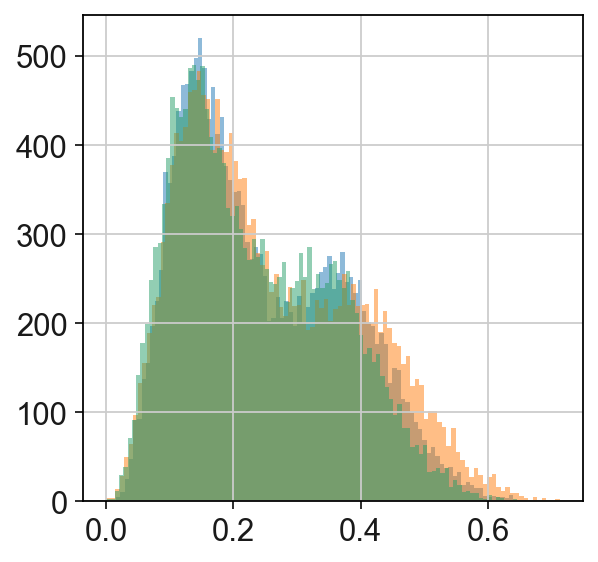

In [17]:
ad_cnv = sc.read(dataPath + 'ad_all_human_clustered_cnv_%s.h5ad' % model)
ad_cnv.obs['CNV burden'] = (ad_cnv.to_df().T!=0).astype(int).mean(axis=0).values
ad_cnv.obs['CNV burden amplifications'] = (ad_cnv.to_df().T>0).astype(int).mean(axis=0).values
ad_cnv.obs['CNV burden deletions'] = (ad_cnv.to_df().T<0).astype(int).mean(axis=0).values
ad_cnv.obs[['original_barcode', 'id', 'CNV burden', 'CNV burden amplifications', 'CNV burden deletions']].to_csv(dataPath + 'CNV_burden_%s.csv' % model)
ad_cnv.obs['CNV burden'].hist(bins=100, alpha=0.5)
(ad_cnv.obs['CNV burden amplifications']*2).hist(bins=100, alpha=0.5)
(ad_cnv.obs['CNV burden deletions']*2).hist(bins=100, alpha=0.5)

In [10]:
palette1.update({id: cm.terrain(0.01 + i/len(ids)) for i, id in enumerate(ids)})

In [6]:
ad_all = sc.read(dataPath + 'ad_all_human_clustered_st_%s.h5ad' % model)
ad_all.shape

(18406, 18720)

In [12]:
df_infercnv_cnv, df_infercnv_meta = loadCNVfromInferCNV(dataPath + 'For_inferCNV_%s_meta.data.tsv.gz' % model, 
                                                        [preprocessedInferCNVDataPath + 'infercnv.references.txt',
                                                         preprocessedInferCNVDataPath + 'infercnv.observations.txt'])

(8897, 18397) (18397, 3)


In [13]:
ad_cnv = sc.AnnData(df_infercnv_cnv.T)
ad_cnv.obs = df_infercnv_meta.loc[ad_cnv.obs.index]
ad_cnv

AnnData object with n_obs × n_vars = 18397 × 8897
    obs: 'sample', 'cluster', 'time'

In [14]:
# ad_cnv = ad_cnv[ad_cnv.obs['time'].isin(['T0', 'T1', 'T2', 'T3', 'T4']), :]
# print(ad_cnv.shape)

In [15]:
ad_cnv.uns['cluster_colors'] = ad_all.uns['%s_colors' % rna_cluster_identity]
ad_cnv.uns['sample_colors'] = ad_all.uns['sample_colors']
ad_cnv.uns['time_colors'] = ad_all.uns['T_colors'] #[2:]
ad_cnv.obs['original_barcode'] = ad_all.obs['original_barcode'].loc[ad_cnv.obs.index]
ad_cnv.obs['id'] = ad_cnv.obs['sample'].replace(dict(zip(sids, ids)))

In [16]:
sc.pp.pca(ad_cnv, n_comps=100, zero_center=True, use_highly_variable=False)
pca_projections = pd.DataFrame(ad_cnv.obsm['X_pca'], index=ad_cnv.obs_names)

computing PCA
    with n_comps=100
    finished (0:00:22)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


... storing 'sample' as categorical
... storing 'cluster' as categorical
... storing 'time' as categorical
... storing 'id' as categorical


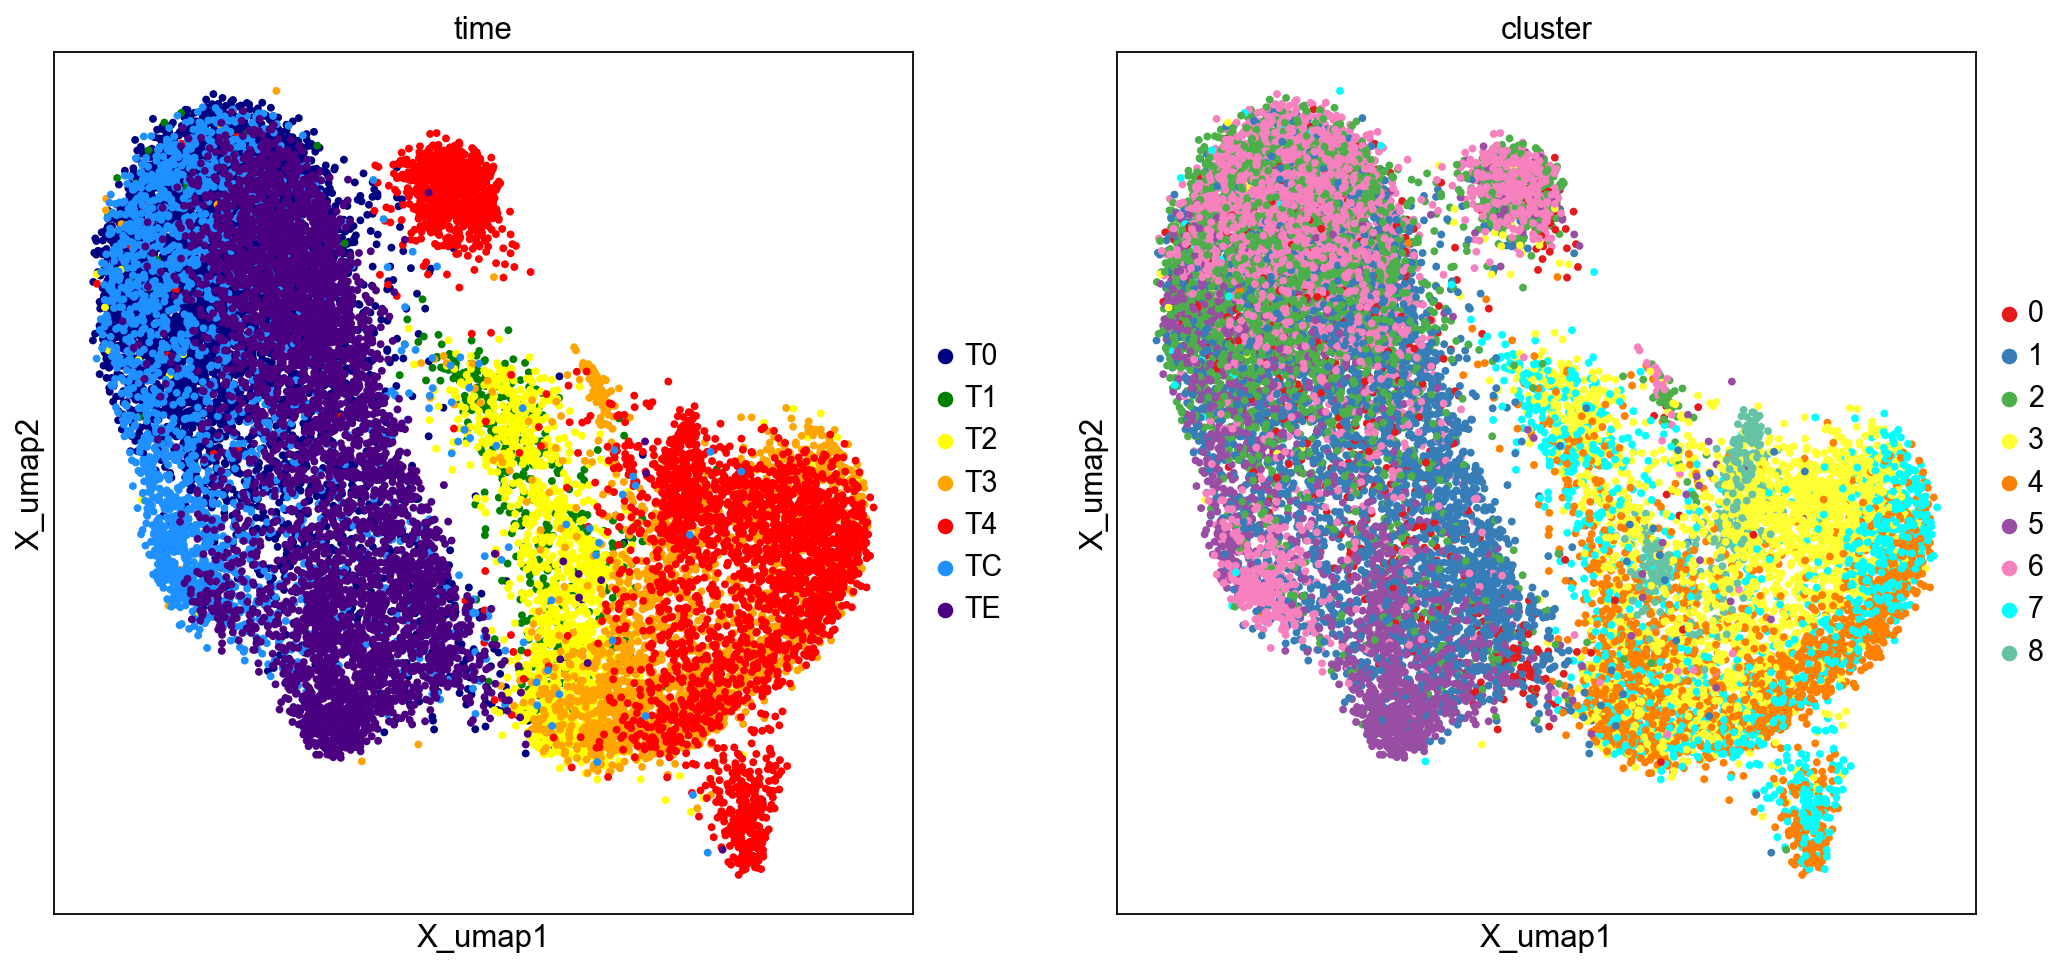

In [17]:
sc.pp.neighbors(ad_cnv, n_neighbors=100, use_rep='X_pca', metric='correlation')
sc.tl.umap(ad_cnv)
plt.rcParams["figure.figsize"] = (7, 7)
sc.pl.embedding(ad_cnv, color=['time', 'cluster'], basis='X_umap', title='time', cmap='nipy_spectral', size=50)

In [18]:
# generate neighbor draph in multiscale diffusion space
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=10)
ad_cnv.obsm['X_palantir']=ms_data.values
sc.pp.neighbors(ad_cnv, n_neighbors=100, use_rep='X_palantir', metric='correlation')

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:24)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


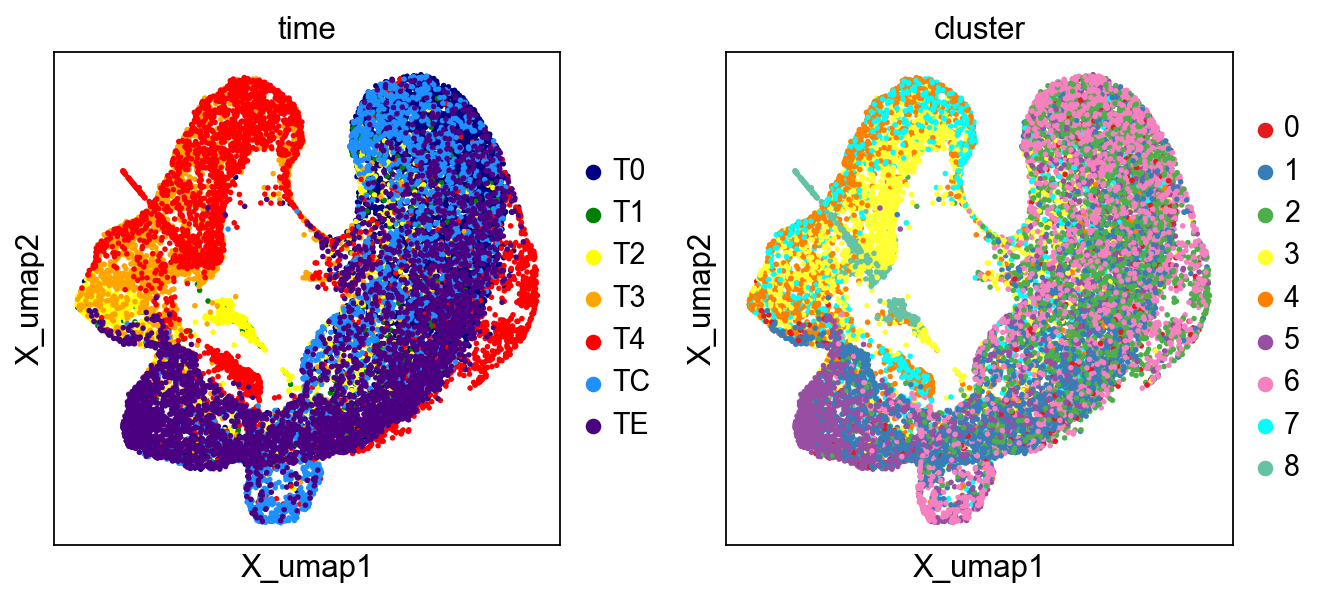

In [19]:
sc.tl.umap(ad_cnv)
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.embedding(ad_cnv, color=['time', 'cluster'], basis="X_umap", title='time', cmap='nipy_spectral', size=25)

running Leiden clustering
    finished: found 12 clusters and added
    'cnv_clusters', the cluster labels (adata.obs, categorical) (0:00:10)


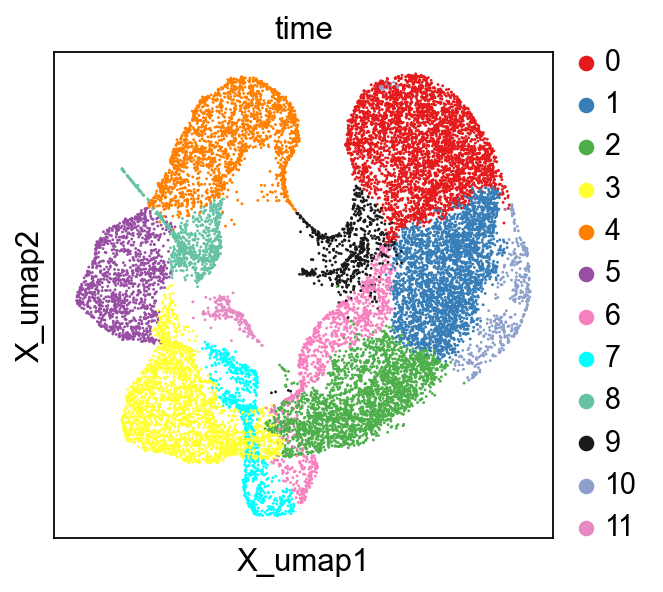

In [20]:
res = 0.25
plt.rcParams["figure.figsize"] = (4, 4)
sc.tl.leiden(ad_cnv, key_added='cnv_clusters', resolution=res)
sc.pl.embedding(ad_cnv, color=['cnv_clusters'], basis="X_umap", title='time', palette=palette1)

In [21]:
ad_cnv.write(dataPath + 'ad_all_human_clustered_cnv_%s.h5ad' % model)

# Load images and create ADs

In [22]:
images = {id: [(ad_temp := sc.read(preprocessedStDataPath + '%s/st_adata_processed.h5ad' % id)).uns['spatial'], ad_temp.obs.index, ad_temp.obsm['spatial']] for id in ids}
ads = dict()
for sample in ids:
    ads[sample] = ad_cnv[ad_cnv.obs['id']==sample, :].copy()    
    ads[sample].uns['spatial'] = images[sample][0]
    ads[sample].obsm['spatial'] = pd.DataFrame(index=images[sample][1], data=images[sample][2]).reindex(ads[sample].obs['original_barcode']).values

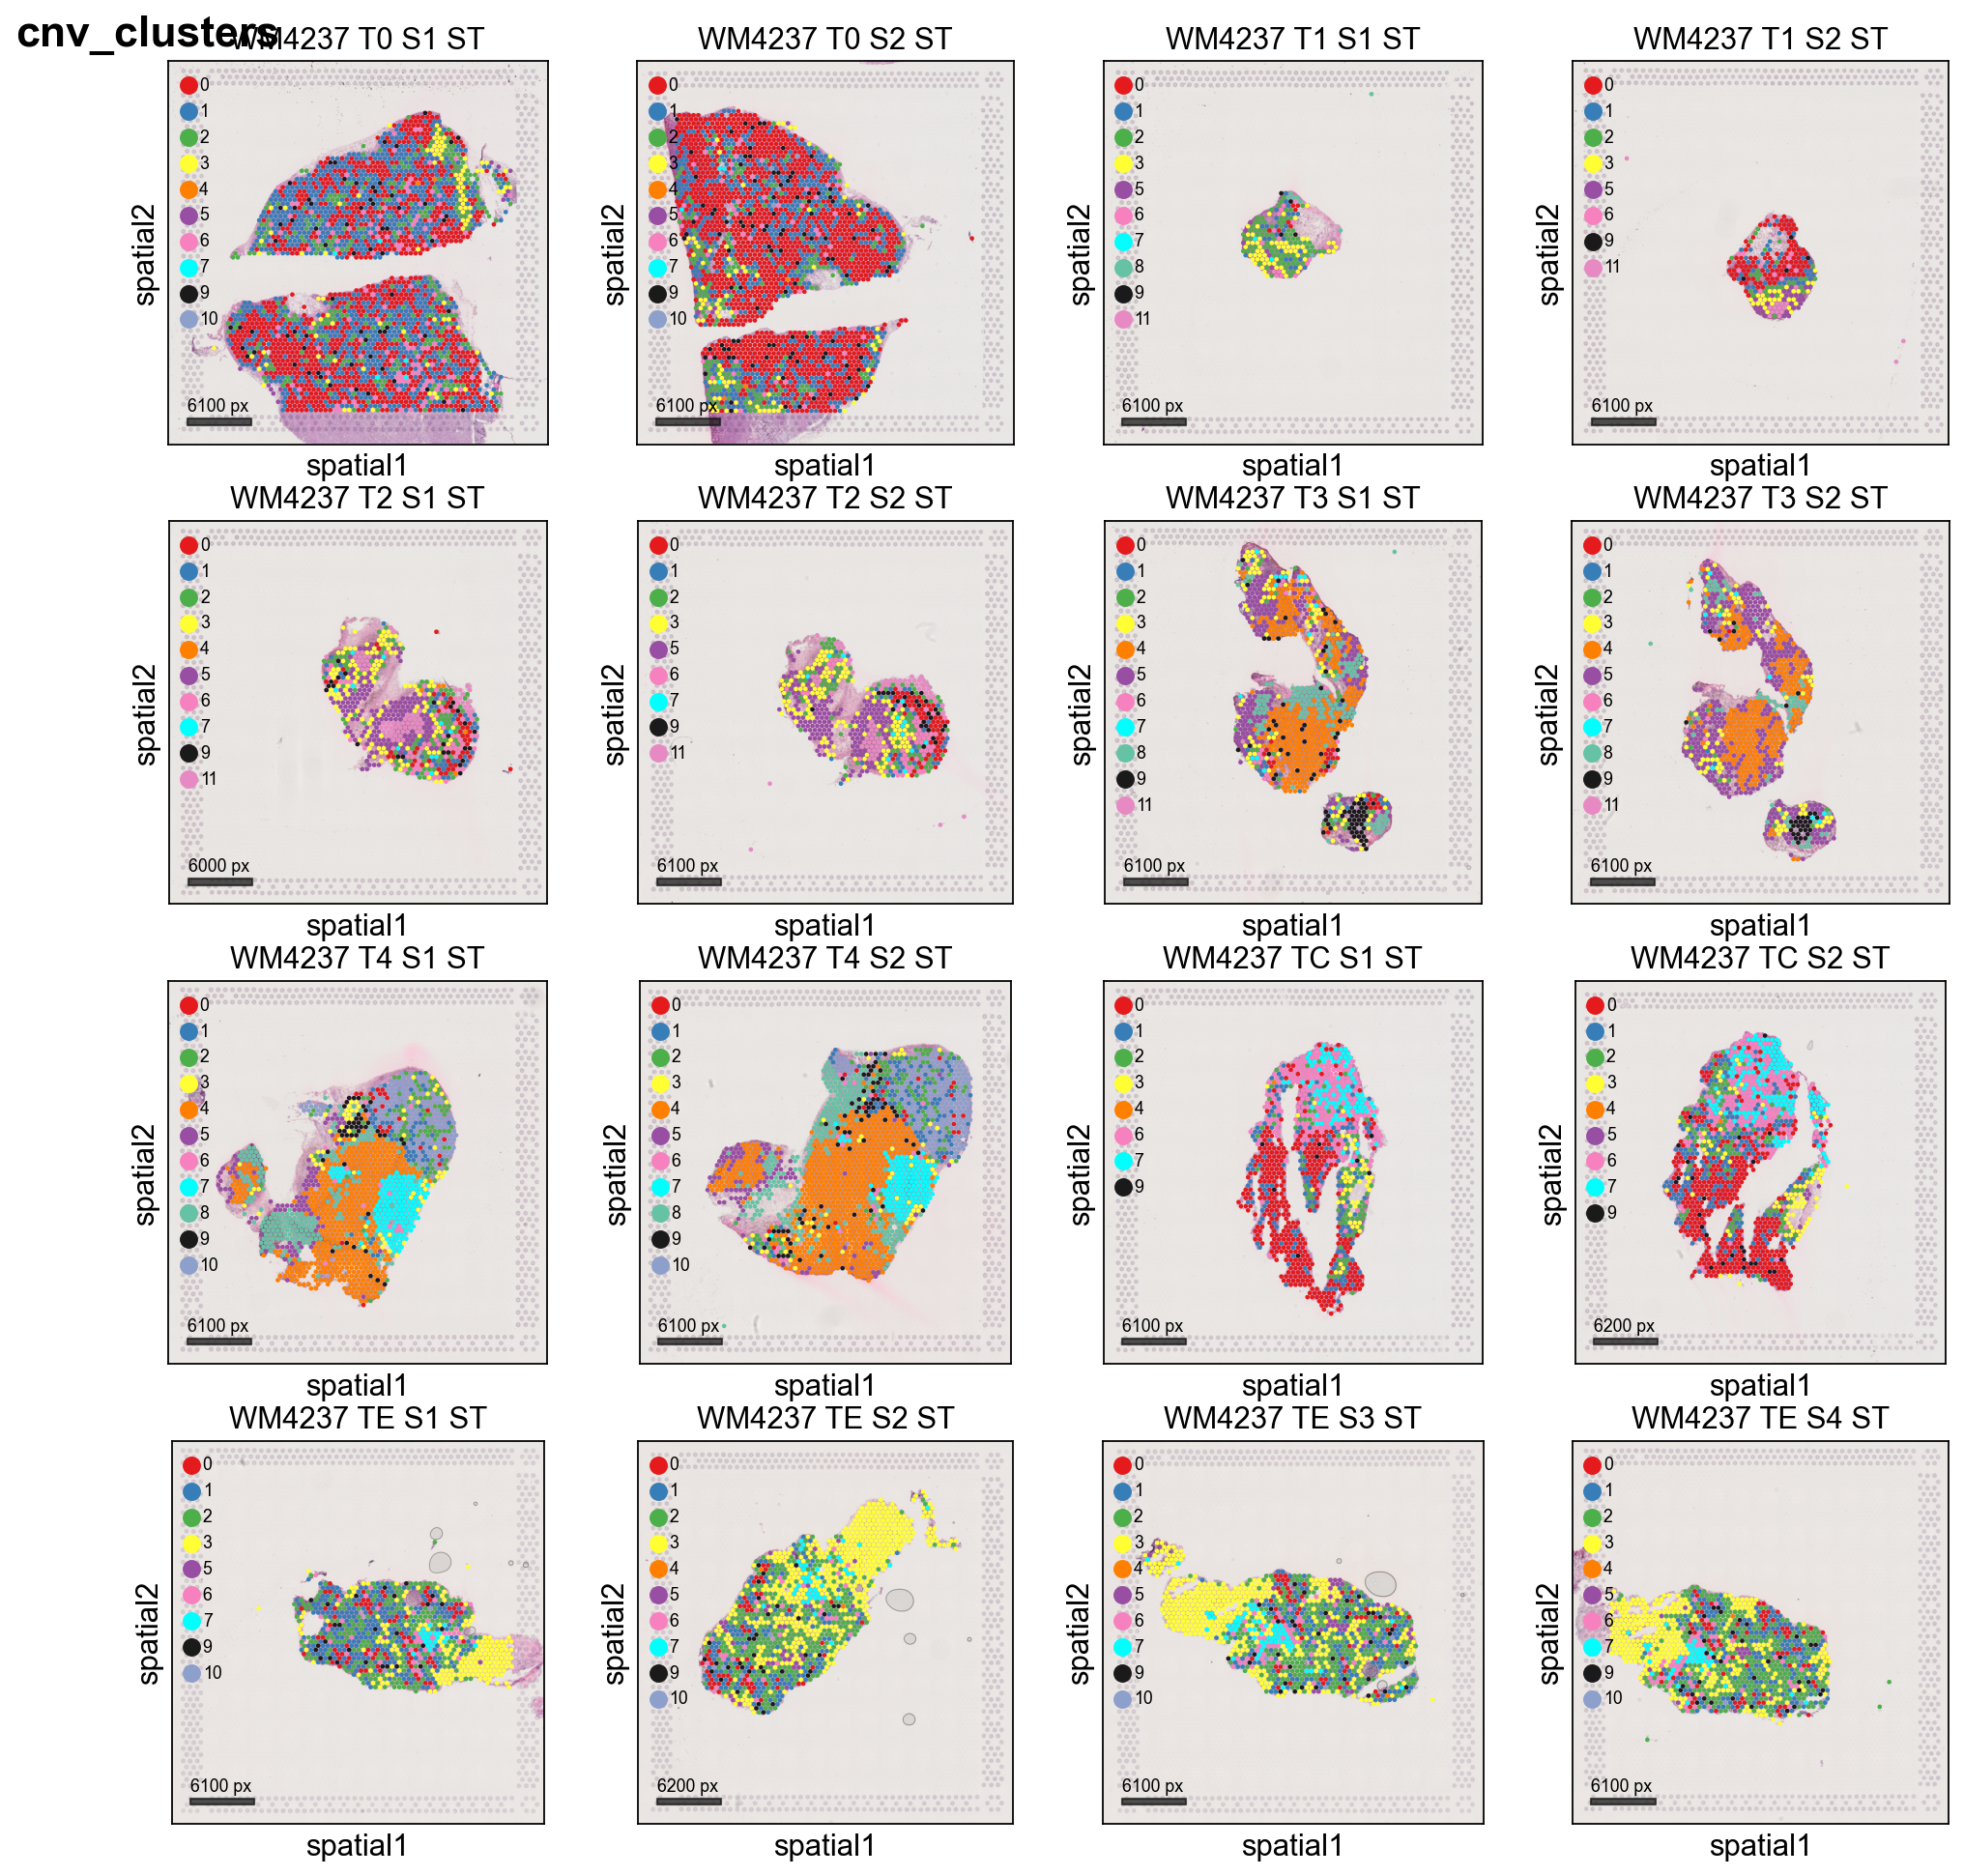

In [23]:
plotSpatialAll(ads, identity='cnv_clusters', palette=palette1, f=0.75)